In [478]:
import random

In [479]:
class Game:
  def __init__(self, players, verbose=False):
    random.shuffle(players)
    self.players = players
    self.history = []
    self.current_bid = -1
    self.winner = None

  def run(self):
    game_finished = False
    abstain_count = 0

    while not game_finished:
      player_count = len(self.players)

      for player in self.players:
        if abstain_count >= player_count - 1:
          game_finished = True
          continue

        bid = player.play(self)
        
        if bid is None or bid > player.balance or bid <= self.current_bid:
          abstain_count += 1
          self.history.append((player, None))
          continue
        else:
          abstain_count = 0
          player.balance -= bid
          self.current_bid = bid
          self.history.append((player, bid))

    winner = self.history[-player_count][0]
    winner.balance += 100
    self.winner = winner

Let's create the an abstract class of player. This class will serve as the base for each player strategy we create. It shouldn't never be instanciated, only inherited.

In [480]:
class AbstractPlayer:
  def __init__(self, name, balance):
    self.name = name
    self.balance = balance

  def __str__(self):
    return f"{self.name}"

  def bid(self, amount):
    return amount

  def abstrain(self):
    return None

  # different stategies
  def play(self, game):
    pass

Let's create a random player, which will bid based on a fair coin flip (50% bid, 50% abstain).

In [481]:
import random

class RandomPlayer(AbstractPlayer):
  def __init__(self, name, balance, increment):
    AbstractPlayer.__init__(self, name, balance)
    self.increment = increment

  def play(self, game: Game):
    player_bids = random.choice([True, False])

    if player_bids:
      return self.bid(game.current_bid + self.increment)

    return self.abstrain()

Let's create a ceiling player, that will bid until it reaches a certain ceiling and abstain afterwords.

In [482]:
class CeilingPlayer(AbstractPlayer):
  def __init__(self, name, balance, ceiling, increment):
    AbstractPlayer.__init__(self, name, balance)
    self.ceiling = ceiling
    self.increment = increment

  def play(self, game: Game):
    if game.history == []:
      return self.bid(0)

    if game.current_bid < self.ceiling:
      return self.bid(game.current_bid + self.increment);

    return self.abstrain()

Let's run a single round of the game, using 2 players (Alice and Bob)

In [483]:
p1 = CeilingPlayer("Alice", balance=1000, ceiling=100, increment=10)
p2 = CeilingPlayer("Bob", balance=1000, ceiling=100, increment=10)

players = [p1, p2]

game = Game(players=players)
game.run()

In [484]:
p1_actions = filter(lambda action: action[0] == p1, game.history)
p2_actions = filter(lambda action: action[0] == p2, game.history)

for player, bid in game.history:
  if bid is None:
    print(f"{player} abstains")
  else:
    print(f"{player} bids {bid}")

Alice bids 0
Bob bids 10
Alice bids 20
Bob bids 30
Alice bids 40
Bob bids 50
Alice bids 60
Bob bids 70
Alice bids 80
Bob bids 90
Alice bids 100
Bob abstains


In [485]:
print(f"Winner: {game.winner}")

for player in players:
  print(f"Balance of {player}: {player.balance}")

Winner: Alice
Balance of Alice: 800
Balance of Bob: 750


Now let's simulate 100 rounds of the game

In [486]:
import numpy as np
import matplotlib.pyplot as plt

In [489]:
ROUNDS = 100

p1 = CeilingPlayer("Alice", balance=5000, ceiling=100, increment=10)
p2 = CeilingPlayer("Bob", balance=5000, ceiling=100, increment=10)

players = [p1, p2]

results = np.zeros((len(players), ROUNDS))

for i in range(ROUNDS):
  game = Game(players=[p1, p2])
  game.run()
  results[0][i] = p1.balance
  results[1][i] = p2.balance

plt.plot(np.linspace(0, ROUNDS, ROUNDS), results[0], label="P1")
plt.plot(np.linspace(0, ROUNDS, ROUNDS), results[1], label="P2")
plt.xlabel('Game #')
plt.ylabel('Player\'s Balance')
plt.legend() 
plt.show()

TypeError: 'builtin_function_or_method' object cannot be interpreted as an integer

From the graph we can see that with each round players lose money, until one of them runs out. After that the remaining player start to win money back from the auctioneer. In this implementation who gets to vote first is determined by random (uniform), thus which player would run out of money first is also determined at random with probability 1/2

Now let's simulate 100 games of 100 rounds and take the averages

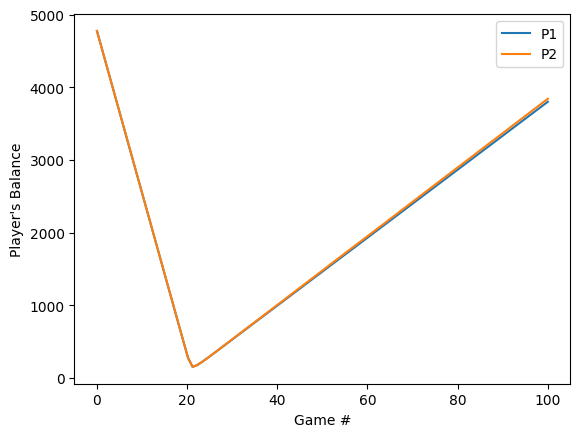

In [488]:
GAMES = 1000
ROUNDS = 100

results = np.zeros((GAMES, 2, ROUNDS))

for i in range(GAMES):
  p1 = CeilingPlayer("Alice", balance=5000, ceiling=100, increment=10)
  p2 = CeilingPlayer("Bob", balance=5000, ceiling=100, increment=10)

  for j in range(ROUNDS):
    game = Game(players=[p1, p2])
    game.run()
    results[i][0][j] = p1.balance
    results[i][1][j] = p2.balance

averages = np.zeros((2, 100))

averages[0] = results[:,0,:].mean(axis=0)
averages[1] = results[:,1,:].mean(axis=0)

plt.plot(np.linspace(0, ROUNDS, ROUNDS), averages[0], label="P1")
plt.plot(np.linspace(0, ROUNDS, ROUNDS), averages[1], label="P2")
plt.xlabel('Game #')
plt.ylabel('Player\'s Balance')
plt.legend() 
plt.show()